In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.optim import Adam
import torch.nn.functional as F
from data import HSIDataLoader, TestDS, TrainDS
import numpy as np
from plot import show_tensor_image,show_spectral_curve
from torch import nn
import math

In [2]:
hsidata = HSIDataLoader({'data':{"pca":0}})
dataloader = hsidata.generate_torch_dataset()


[data] load data shape data=(145, 145, 200), label=(145, 145)
------[data] after transpose train, test------
Y_test shape : (1, 200, 145, 145)
------final--------
X.shape= (1, 200, 145, 145)
Y.shape= (1, 145, 145)


(1, 200, 145, 145)
(1, 1, 200, 145, 145) (1, 1, 145, 145) (1, 200, 145, 145) (1, 145, 145)
[66] [98]


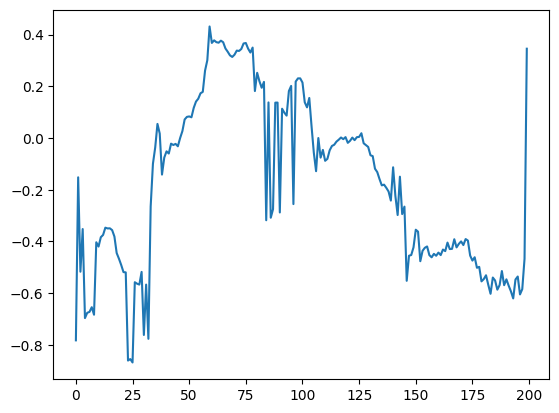

In [3]:
X, Y = hsidata.get_X_Y() 
print(X.shape)
X = X * 2 - 1
newX = np.expand_dims(X,0)
newY = np.expand_dims(Y,0)
print(newX.shape, newY.shape, X.shape, Y.shape)
all_data_loader = torch.utils.data.DataLoader(dataset=TrainDS(newX,newY),
                                            batch_size=1,
                                            shuffle=False,
                                            num_workers=0)
# show_spectral_curve(X,X,Y)

def get_one(c=1):
    num = 6
    a = 0
    for i in range(145):
        for j in range(145):
            if Y[0,i,j] == c:
                a += 1
                if a == num:
                    return (i,j)

sample_h = []
sample_w = []
for l in range(1):
    qq,xx = get_one(l+1)
    sample_h.append(qq)
    sample_w.append(xx)
print(sample_h, sample_w)

sam = X[0,:,sample_h,sample_w]
l = sam.shape[1]
for i in range(sam.shape[0]):
    plt.plot(list(range(l)), sam[i])
# plt.plot(list(range(sam.shape[0])), sam)


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific  q index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred),x_noisy, noise, noise_pred


# Define beta schedule
T = 100
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [5]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

class Block3d(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv3d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose3d(out_ch, out_ch, (4,3,3), (2,1,1), (1,1,1))
        else:
            self.conv1 = nn.Conv3d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv3d(out_ch, out_ch, (4,3,3), (2,1,1), (1,1,1))
        self.conv2 = nn.Conv3d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm3d(out_ch)
        self.bnorm2 = nn.BatchNorm3d(out_ch)
        self.relu  = nn.ReLU()
        
        

class Block3dNew(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, kernal=(4,3,3), stride=(2,1,1), padding=(1,1,1), up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv3d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose3d(out_ch, out_ch, kernal, stride, padding)
        else:
            self.conv1 = nn.Conv3d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv3d(out_ch, out_ch, kernal, stride, padding)
        self.conv2 = nn.Conv3d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm3d(out_ch)
        self.bnorm2 = nn.BatchNorm3d(out_ch)
        self.relu  = nn.ReLU()
        
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 3]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)
        

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self, _image_channels):
        super().__init__()
        image_channels = _image_channels 
        down_channels = (8,8,16)
        down_params = [
            [(4,3,3),(4,1,1),(1,1,1)],
            [(4,3,3),(2,1,1),(1,1,1)]
        ]
        up_channels = (16,8,8)
        up_params = [
            [(4,3,3),(2,1,1),(1,1,1)],
            [(4,3,3),(4,1,1),(0,1,1)]
        ]
        out_dim = 1 
        time_emb_dim = 32
        self.features = []

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv3d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block3dNew(down_channels[i], down_channels[i+1], time_emb_dim, \
                                     down_params[i][0], down_params[i][1], down_params[i][2]) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block3dNew(up_channels[i], up_channels[i+1], time_emb_dim, \
                                     up_params[i][0], up_params[i][1], up_params[i][2], up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv3d(up_channels[-1], image_channels, out_dim)

    def forward(self, x, timestep, feature=False):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
            # print("down" , x.shape)
        for up in self.ups:
            residual_x = residual_inputs.pop()
#             print("down=",residual_x.shape, "up=", x.shape)
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1) 
            if feature:
                self.features.append(x.detach().cpu().numpy())
            x = up(x, t)
        return self.output(x)
    def return_features(self):
        temp_features = []
        for f in self.features:
            batch, channel, spe, w, h = f.shape
            temp_features.append(f.reshape(-1,w,h))
        return np.concatenate(temp_features, axis=0)
            

In [6]:
batch, channel, spe, weight, height = newX.shape
model = SimpleUnet(_image_channels=channel)
model.to(device)
optimizer = Adam(model.parameters(), lr=0.01)
epochs = 1000 # Try more!
BATCH_SIZE = batch
IMG_SIZE = weight

In [7]:
@torch.no_grad()
def sample_timestep(x, t, features=False):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t, features) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    up_features = model.return_features()
    if t == 0:
        return model_mean, up_features
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise , up_features

@torch.no_grad()  
def save_all_data(x0, path, nums=10):
    step_size = T // nums
    x_list = []
    up_feature_list = []
    use_index = []
    t = torch.full((1,), T-1, device=device, dtype=torch.long)
    xt, tmp_noise = forward_diffusion_sample(x0, t, device)
    res_image = []
    for i in range(0,T)[::-1]: # from T-1 -> 0
        t = torch.full((1,), i, device=device, dtype=torch.long)
        xt, up_features = sample_timestep(xt, t, features=True)
        if i % step_size == 0:
            use_index.append(i)
            up_feature_list.append(up_features)
            x_list.append(xt.detach().cpu().numpy())
    #save to dir
    np_use_index = np.asarray(use_index)
    np_up_feature = np.stack(up_feature_list, axis=0)
    np_x_list = np.stack(x_list, axis=0)
    np_xt = np.asarray(xt)
    np_noise = np.asarray(tmp_noise)
    
    np_use_index.tofile('%s/index.bin' % path)
    np_up_feature.tofile('%s/feature.bin' % path)
    np_x_list.tofile('%s/recon_xt.bin' % path)
    np_xt.tofile('%s/xt.bin' % path)
    np_noise.tofile('%s/noise.bin' % path)
    print('save data done!')
    
    
    
@torch.no_grad()
def sample_plot_image(x0):
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn(x0.shape, device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 9
    stepsize = int(T/num_images)

    plt.subplot(1, int(num_images)+1, 1)
    show_tensor_image(newX,rgb=(-3,-2,-1))
    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img,_ = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, int(num_images)+2, int(i/stepsize)+2)
            show_tensor_image(img.detach().cpu())
    plt.show() 
    
    plt.figure(figsize=(15,15))
    plt.axis('off')
    #输入xt情况下
    plt.subplot(1, int(num_images)+1, 1)
    show_tensor_image(newX)
    t = torch.full((1,), T-1, device=device, dtype=torch.long)
    xt, tmp_noise = forward_diffusion_sample(x0, t, device)
    res_image = []
    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        xt = sample_timestep(xt, t)
        if i % stepsize == 0:
            plt.subplot(1, int(num_images)+2, int(i/stepsize)+2)
            temp_img = xt.detach().cpu()
            res_image.append(temp_img)
            show_tensor_image(temp_img)
    plt.show()
    
    plt.figure(figsize=(20,8))
    res_image = [res_image[-1]]
    for k,temp in enumerate(res_image):
        img = temp.numpy()[0,0]
#         plt.subplot(1, len(res_image)+1, k+1)
        img_data = img[:,sample_h, sample_w]
        x_data = X[0,:, sample_h, sample_w]
        print(X.shape, x_data.shape)
        band, num = img_data.shape
        for j in range(num):
            plt.plot(img_data[:,j],linestyle='-.', label='pred')
            plt.plot(x_data[j,:], label='real')
            plt.legend()
    plt.show()
        
    

In [8]:
check = False
for epoch in range(epochs):
    for step, (batch, _) in enumerate(all_data_loader):

        batch = batch.to(device)
#         print(type(batch), batch.shape)
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss, temp_xt, temp_noise, temp_noise_pred = get_loss(model, batch, t)
        loss.backward()
        optimizer.step()

        if epoch % 20 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
#             sample_plot_image(batch)

        if loss.item() < 1:
            print('start to save data, epoch=%s, loss=%s' % (str(epoch),str(loss.item())))
            save_all_data(batch, './feature_data')
            check = True
            break
    if check:
        break

Epoch 0 | step 000 Loss: 0.8137726783752441 
start to save data, epoch=0, loss=0.8137726783752441


MemoryError: Unable to allocate 6.64 GiB for an array with shape (84800, 145, 145) and data type float32

In [ ]:
Y.shape

In [ ]:
list(range(0,T)[::-1])

In [ ]:
img = X[0]

In [10]:
84800*145*145*4 / 1024 / 1024 / 1024

6.641894578933716